<a href="https://colab.research.google.com/github/MaxOng94/NLP-projects/blob/master/Matamorphosis_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf 
import keras
import numpy as np

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


Clean text 

1) Lower case all the words 

2) Remove punctuation from words to reduce vocab size 

3) Remove words that are not alphabetic and numeric

We can use keras's tokenizer to help us. 

In [3]:
file_path = '/content/drive/My Drive/Colab Notebooks/NLP/Text generator/metamorphosis_cleaned.txt'
text = open(file_path,"r").read()
text[0:100]

'One morning, when Gregor Samsa woke from troubled dreams, he found\nhimself transformed in his bed in'

In [ ]:
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
text = open("metamorphosis_cleaned.txt","r").read()
text = text.lower()
# [^\w] --> everything except alpabetical n numeric characters
# compile[^\w] into an object called pattern
pattern = re.compile(r"[^\w]") 
# to substitude anything that falls into the pattern object with empty space " "
text = re.sub(pattern," ",text)
# becomes a list of tokens
text = word_tokenize(text)
text= [i for i in text if i.isalpha()]
text = [i for i in text if len(i) >=2 ]
print(text[:20])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['one', 'morning', 'when', 'gregor', 'samsa', 'woke', 'from', 'troubled', 'dreams', 'he', 'found', 'himself', 'transformed', 'in', 'his', 'bed', 'into', 'horrible', 'vermin', 'he']


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
print("Unique tokens :",len(tokenizer.word_index))
print("Length of text :",len(text))

# vocab size is always + 1
vocab_size = len(tokenizer.word_index) + 1

Unique tokens : 2960
Length of text : 24638


We will arbitrarily select 50 as our seq_length. The seq_length represents the context our lstm can take into account when learning long-term dependencies. Thus this can be tuned. 


To organize the list of tokens into sequences of 50 input and 1 output word. 
This will be a many to one LSTM 

In [ ]:
length = 50 + 1
sequences = list()

for i in range(length,len(text)):
  seq = text[i-length:i] # tokens[0:51],tokens[1:52] this ensures that we will produce range of text of length 51 all the time. 
  # convert the list of tokens into a line 
  line = " ".join(seq)
  # store these sentences of length 51 into our list 
  sequences.append(line)
  # now we have a nice list of strings each length 51


  # we can then split these lengths of 51 text into input (first 50) and output (51th)
  # this means that we can have a nice and clean pair of inputs (index 0 - 50) and output(51th )

In [ ]:
print("Total training sequences: ",len(sequences))

Total training sequences:  24587


In [ ]:
print(sequences[:1])
print(sequences[1:2])
print(sequences[2:3])

['one morning when gregor samsa woke from troubled dreams he found himself transformed in his bed into horrible vermin he lay on his armour like back and if he lifted his head little he could see his brown belly slightly domed and divided by arches into stiff sections the bedding was']
['morning when gregor samsa woke from troubled dreams he found himself transformed in his bed into horrible vermin he lay on his armour like back and if he lifted his head little he could see his brown belly slightly domed and divided by arches into stiff sections the bedding was hardly']
['when gregor samsa woke from troubled dreams he found himself transformed in his bed into horrible vermin he lay on his armour like back and if he lifted his head little he could see his brown belly slightly domed and divided by arches into stiff sections the bedding was hardly able']


Since we already fitted our tokenizer object, we can call the method texts_to_seq to transform our training sequences /examples into integers


In [ ]:
sequence = tokenizer.texts_to_sequences(sequences)
# sequence type is a list of list 
print(sequence[0])
print(sequence[1])
print(sequence[2])

[56, 152, 62, 12, 102, 1061, 28, 1513, 1062, 4, 220, 44, 1514, 8, 5, 119, 53, 813, 1515, 4, 173, 23, 5, 1516, 92, 50, 3, 31, 4, 500, 5, 93, 75, 4, 32, 81, 5, 664, 814, 389, 1517, 3, 1518, 55, 1519, 53, 815, 1063, 1, 1520, 7]
[152, 62, 12, 102, 1061, 28, 1513, 1062, 4, 220, 44, 1514, 8, 5, 119, 53, 813, 1515, 4, 173, 23, 5, 1516, 92, 50, 3, 31, 4, 500, 5, 93, 75, 4, 32, 81, 5, 664, 814, 389, 1517, 3, 1518, 55, 1519, 53, 815, 1063, 1, 1520, 7, 221]
[62, 12, 102, 1061, 28, 1513, 1062, 4, 220, 44, 1514, 8, 5, 119, 53, 813, 1515, 4, 173, 23, 5, 1516, 92, 50, 3, 31, 4, 500, 5, 93, 75, 4, 32, 81, 5, 664, 814, 389, 1517, 3, 1518, 55, 1519, 53, 815, 1063, 1, 1520, 7, 221, 146]


Our sequence type is currently a list of list. Changing it to numpy array.

To create the sequence inputs and outputs 

In [ ]:
a = np.array([[1,2,3,4]])
a[:,-1]

array([4])

In [ ]:
sequence= np.array(sequence)
print("Shape of sequence ", sequence.shape)
X,y = sequence[:,:50], sequence[:,-1]
# y to one hot encode to vocab size (2960) +1
y = tf.keras.utils.to_categorical(y,num_classes = vocab_size)
print("Shape of X : ", X.shape)
print("Shape of y : ",y.shape)

Shape of sequence  (24587, 51)
Shape of X :  (24587, 50)
Shape of y :  (24587, 2961)


Because our archietecture is a many to one architecture, our output is only 1 given 50 input.

Fit our model 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            148050    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 50)            20200     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 2961)              2

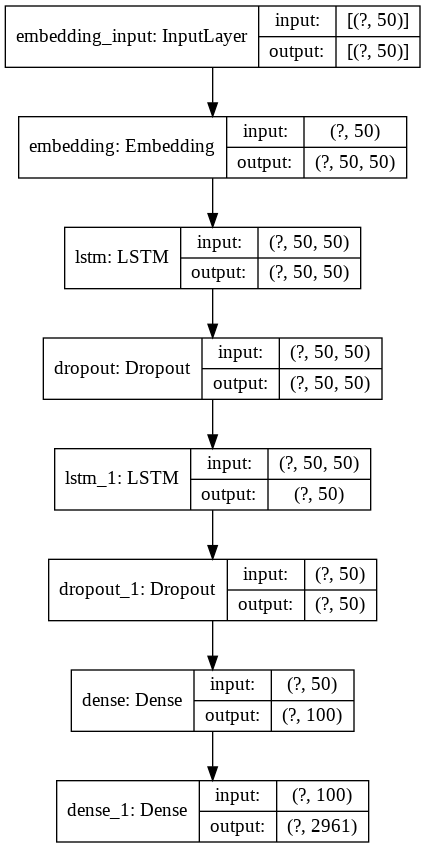

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

seq_length = 50 # inputs is 50
def model(vocab_size, seq_length):
  model = Sequential()

  model.add(Embedding(input_dim = vocab_size, output_dim = 50, input_length = seq_length))
  # return sequences returns the hidden state of lstm, so the output of this 
  # lstm layer is 3d. 
  # we set return sequence = True when stacking lstm layers
  model.add(LSTM(50, return_sequences = True))
  model.add(Dropout(0.1))
  model.add(LSTM(50))
  model.add(Dropout(0.1))
  model.add(Dense(100, activation = "relu"))
  model.add(Dense(vocab_size, activation = "softmax"))
  
  model.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])
  model.summary()
  return model 
model = model(vocab_size, seq_length)
plot_model(model,show_shapes = True)

In [ ]:
model.fit(X,y,batch_size = 128, epochs = 100)

Epoch 1/100
193/193 [==============================] - 21s 111ms/step - loss: 6.2160 - accuracy: 0.0539
Epoch 2/100
193/193 [==============================] - 22s 116ms/step - loss: 6.0701 - accuracy: 0.0539
Epoch 3/100
193/193 [==============================] - 23s 117ms/step - loss: 5.9872 - accuracy: 0.0558
Epoch 4/100
193/193 [==============================] - 23s 119ms/step - loss: 5.8605 - accuracy: 0.0616
Epoch 5/100
193/193 [==============================] - 23s 118ms/step - loss: 5.7571 - accuracy: 0.0670
Epoch 6/100
193/193 [==============================] - 23s 120ms/step - loss: 5.6508 - accuracy: 0.0735
Epoch 7/100
193/193 [==============================] - 23s 118ms/step - loss: 5.4968 - accuracy: 0.0820
Epoch 8/100
193/193 [==============================] - 23s 118ms/step - loss: 5.3560 - accuracy: 0.0911
Epoch 9/100
193/193 [==============================] - 23s 117ms/step - loss: 5.2546 - accuracy: 0.0964
Epoch 10/100
193/193 [==============================] - 22s 116m

In [8]:
from tensorflow.keras.models import load_model
filepath_to_model = '/content/drive/My Drive/Colab Notebooks/NLP/Text generator/matamorphosis_model.h5'
saved_model = load_model(filepath_to_model)

In [ ]:


saved_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            148050    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 2961)             

In [ ]:
saved_model.fit(X,y,batch_size = 128, epochs = 1)

193/193 [==============================] - 22s 112ms/step - loss: 2.5393 - accuracy: 0.3669


Generate text 

1) First step is to prepare a seed input 

  Randomly select a line of text fro input text for this pupose.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def generate_seq(model, tokenizer,seq_length,seed_text ,n_words):
  # empty list too append our predicted output  
  result = []
  in_text = seed_text
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]

    # truncate the sequence to fixed length 
    # because we are adding the new output text to the end of our previous input text, 
    # we will always remove a word from the start of the input text to ensure that the size 
    # remains at 50 
    encoded = pad_sequences([encoded], maxlen = seq_length, truncating = "pre")
    # use predict_class 
    yhat = model.predict_classes(encoded, verbose = 0)
    #yhat = np.argmax(model,axis = 1)
    out_word = ""
    for word,index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word 
        break
      # append to input 
    in_text += " "+ out_word
    result.append(out_word)
  return " ".join(result)

In [ ]:
seed_text = sequences[np.random.randint(0,len(sequences))]


In [ ]:
generated = generate_seq(saved_model,tokenizer,seq_length,seed_text,100)
print(seed_text)
print("_"* 50)
print(generated)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
the first good news that gregor heard since he had first been incarcerated in his room he had thought that nothing at all remained from his father business at least he had never told him anything different and gregor had never asked him about it anyway their business misfortune had reduced
__________________________________________________
the lad the fresh air enquiries studies living collection from changing the white charwoman with the three gentlemen had stopped me there else as the cleaner had been chosen insistent and he was quite different longer slow to swallow some unheard of posture with the kitchen joining with their buttons and noses yet it was n